In [1]:
from cmb.configs.utils import Configs

config = Configs('classifier.yaml') 


In [2]:
config.print()

experiment:
    type: classifier
    name: multi_model
    workdir: /home/df630/CMB/metrics
data:
    params:
        min_num_particles: 0
        max_num_particles: 128
    train:
        name: Generated
        path: ['/Users/dario/Dropbox/PROJECTS/ML/JetData/JetClass/samples/QCD-8k-set1/gen_sample_QCD-10k-finetune.parquet', '/Users/dario/Dropbox/PROJECTS/ML/JetData/JetClass/samples/QCD-8k-set1/gen_sample_QCD-10k-fromscratch.parquet']
    test:
        name: JetClass
        path: ['/Users/dario/Dropbox/PROJECTS/ML/JetData/JetClass/JetClass_Pythia_train_100M_part0/TTBar_001.root']
    dim:
        continuous: 3
        discrete: 1
    vocab:
        size: 8
    preprocess:
        continuous: standardize
        discrete: states
model:
    name: ParticleNet
    dim:
        embed:
            time: 16
            features:
                continuous: 16
                discrete: 16
            context:
                continuous: 0
                discrete: 0
        hidden:
        

In [11]:
import torch
from cmb.datasets.utils import extract_jetclass_features, extract_aoj_features

class ClassifierMetric:
    def __init__(self, config):

        self.continuous = []
        self.discrete = []
        self.mask = []
        self.class_label = []
        params = config.data.params.to_dict()

        if 'JetClass' in config.data.test.name:
            continuous, discrete, mask = extract_jetclass_features(config.data.test.path, **params)
            label = torch.zeros(continuous.shape[0], 1)
            self.continuous.append(continuous)
            self.discrete.append(discrete)
            self.mask.append(mask)
            self.class_label.append(label)

        elif 'AspenOpenJets' in config.data.test.name:
            continuous, self.discrete, self.mask = extract_aoj_features(config.data.test.path, **params)

        for i, data in enumerate(config.data.train.path):
            i+=1
            




In [12]:
from cmb.models.trainers import GenerativeDynamicsModule
cmb = ClassifierMetric(config)


In [17]:
cmb.class_label[0].shape

torch.Size([100000, 1])

In [1]:
import torch
import numpy as np
import awkward as ak
import fastjet
import vector
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from dataclasses import dataclass
plt.rcParams['mathtext.fontset']= 'cm'
plt.rcParams['figure.autolayout'] = False

vector.register_awkward()

from cmb.datasets.utils import (extract_jetclass_features, 
                                extract_aoj_features, 
                                sample_noise, 
                                sample_masks, 
                                flavor_to_onehot, 
                                states_to_flavor)

class JetDataclass:
    ''' class that prepares the source-target coupling
    '''
    def __init__(self, config, task, num_jets=None):
        assert task=='train' or task=='test', 'Please specify downstream task: `train`, `test`'
        kwargs_target = config.target.params.to_dict()
        kwargs_source = config.source.params.to_dict()
        
        #...target:

        self.target = ParticleClouds(dataset=config.target.name,
                                     data_paths=getattr(config.target.train, 'path', None) if task == 'train' else getattr(config.target.test, 'path', None),
                                     **kwargs_target)

        #... noise source:
        
        kwargs_source['set_masks_like'] = self.target.multiplicity 
        kwargs_source['num_jets'] = len(self.target) if num_jets is None else num_jets

        self.source = ParticleClouds(dataset=config.source.name,
                                     data_paths=getattr(config.source.train, 'path', None) if task == 'train' else getattr(config.source.test, 'path', None),
                                     **kwargs_source)        

class ParticleClouds:
    def __init__(self, 
                 dataset='JetClass',
                 data_paths=None,
                 **data_params
                 ):
    
        if isinstance(dataset, torch.Tensor):
            self.continuous, self.discrete, self.mask  = dataset[..., :3], dataset[..., 3:-1].long(), dataset[..., -1].unsqueeze(-1).long()
            if not self.discrete.nelement():
                del self.discrete

        elif 'JetClass' in dataset:
            assert data_paths is not None, 'Specify the path to the JetClass dataset'
            self.continuous, self.discrete, self.mask = extract_jetclass_features(data_paths,  **data_params)
       
        elif 'AspenOpenJets' in dataset:
            assert data_paths is not None, 'Specify the path to the AspenOpenJet dataset'
            self.continuous, self.discrete, self.mask = extract_aoj_features(data_paths, **data_params)

        elif 'Noise' in dataset:
            self.continuous, self.discrete = sample_noise(dataset, **data_params) 
            self.mask = sample_masks(**data_params)
            self.continuous *= self.mask
            self.discrete *= self.mask

        #...attributes:

        self.pt = self.continuous[...,0] 
        self.eta_rel = self.continuous[...,1]
        self.phi_rel = self.continuous[...,2]
        self.multiplicity = torch.sum(self.mask, dim=1)

        if hasattr(self,'discrete'):
            self.flavor = self.discrete[..., :-1]
            self.charge = self.discrete[..., -1]


    def __len__(self):
        return self.continuous.shape[0]

    def compute_4mom(self):
        self.px = self.pt * torch.cos(self.phi_rel)
        self.py = self.pt * torch.sin(self.phi_rel)
        self.pz = self.pt * torch.sinh(self.eta_rel)
        self.e = self.pt * torch.cosh(self.eta_rel)
        
    #...data processing methods

    def summary_stats(self):
        mask = self.mask.squeeze(-1) > 0
        data = self.continuous[mask]
        return {'mean': data.mean(0).tolist(),
                'std': data.std(0).tolist(),
                'min': data.min(0).values.tolist(),
                'max': data.max(0).values.tolist()}

    def preprocess(self, 
                   output_continuous='standardize', 
                   output_discrete='states',
                   stats=None):
        
        if output_discrete == 'onehot_dequantize':
            one_hot = flavor_to_onehot(self.discrete[..., :-1],  self.discrete[..., -1])
            self.continuous = torch.cat([self.continuous, one_hot], dim=-1)
            del self.discrete
        elif output_discrete == 'states':
            one_hot = flavor_to_onehot(self.discrete[..., :-1],  self.discrete[..., -1])
            self.discrete = torch.argmax(one_hot, dim=-1).unsqueeze(-1).long()

        if output_continuous == 'standardize':
            self.stats = self.summary_stats() if stats is None else stats
            self.continuous = (self.continuous - torch.tensor(self.stats['mean'])) / (torch.tensor(self.stats['std'])) 
            self.continuous *= self.mask
            self.pt = self.continuous[...,0] 
            self.eta_rel = self.continuous[...,1]
            self.phi_rel = self.continuous[...,2]

    def postprocess(self, 
                    input_continuous='standardize', 
                    input_discrete='states',
                    stats=None):
        
        if input_continuous == 'standardize':                 
            if input_discrete == 'onehot_dequantize':
                self.continuous = torch.cat([self.continuous, self.discrete], dim=-1)
                
            stats = getattr(self, 'stats', stats)
            self.continuous = (self.continuous * torch.tensor(stats['std'])) + torch.tensor(stats['mean'])
            self.continuous *= self.mask
            self.pt = self.continuous[...,0] 
            self.eta_rel = self.continuous[...,1]
            self.phi_rel = self.continuous[...,2]

        if input_discrete == 'onehot_dequantize':
            discrete = torch.argmax(self.continuous[...,3:], dim=-1).unsqueeze(-1).long()
            self.flavor, self.charge = states_to_flavor(discrete)
            self.discrete = torch.cat([self.flavor, self.charge], dim=-1)
            self.flavor *= self.mask
            self.charge *= self.mask
            self.discrete *= self.mask
            self.continuous = self.continuous[...,:3]

        if input_discrete == 'states':
            self.flavor, self.charge = states_to_flavor(self.discrete)
            self.discrete = torch.cat([self.flavor, self.charge], dim=-1)
            self.flavor *= self.mask
            self.charge *= self.mask
            self.discrete *= self.mask            

    #...data visualization methods

    def histplot(self, feature='pt',  idx=None, xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), fontsize=12, ax=None, **kwargs):
        mask = self.mask.squeeze(-1) > 0
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        x = getattr(self, feature)[mask] if idx is None else getattr(self, feature)[:,idx]
        sns.histplot(x=x, element="step", ax=ax, **kwargs) 
        ax.set_xlabel(feature if xlabel is None else xlabel, fontsize=fontsize)
        ax.set_ylabel(ylabel, fontsize=fontsize)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def display_cloud(self, idx, scale_marker=1.0, ax=None, figsize=(3,3), facecolor='whitesmoke', color='darkblue', title_box_anchor=(1.025,1.125), savefig=None):
        eta = self.eta_rel[idx]
        phi = self.phi_rel[idx]
        pt = self.pt[idx] * scale_marker 
        flavor = torch.argmax(self.flavor[idx], dim=-1)
        q = self.charge[idx]
        mask = self.mask[idx]
        pt = pt[mask.squeeze(-1) > 0]
        eta = eta[mask.squeeze(-1) > 0]
        phi = phi[mask.squeeze(-1) > 0]
        flavor = flavor[mask.squeeze(-1) > 0]
        charge = q[mask.squeeze(-1) > 0]

        if ax is None: _, ax = plt.subplots(figsize=figsize)            

        ax.scatter(eta[flavor==0], phi[flavor==0], marker='o', s=pt[flavor==0], color='gold', alpha=0.5,  label=r'$\gamma$')
        ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=pt[flavor==1], color='darkred', alpha=0.5, label=r'$h^{0}$')
        ax.scatter(eta[(flavor==2) & (charge<0)], phi[(flavor==2) & (charge<0)], marker='^', s=pt[(flavor==2) & (charge<0)], color='darkred', alpha=0.5,  label=r'$h^{-}$')
        ax.scatter(eta[(flavor==2) & (charge>0)], phi[(flavor==2) & (charge>0)], marker='v', s=pt[(flavor==2) & (charge>0)], color='darkred', alpha=0.5,  label=r'$h^{+}$')
        ax.scatter(eta[(flavor==3) & (charge<0)], phi[(flavor==3) & (charge<0)], marker='^', s=pt[(flavor==3) & (charge<0)], color='blue', alpha=0.5,  label=r'$e^{-}$')
        ax.scatter(eta[(flavor==3) & (charge>0)], phi[(flavor==3) & (charge>0)], marker='v', s=pt[(flavor==3) & (charge>0)], color='blue', alpha=0.5,  label=r'$e^{+}$')
        ax.scatter(eta[(flavor==4) & (charge<0)], phi[(flavor==4) & (charge<0)], marker='^', s=pt[(flavor==4) & (charge<0)], color='green', alpha=0.5,  label=r'$\mu^{-}$')
        ax.scatter(eta[(flavor==4) & (charge>0)], phi[(flavor==4) & (charge>0)], marker='v', s=pt[(flavor==4) & (charge>0)], color='green', alpha=0.5,  label=r'$\mu^{+}$')

        # Define custom legend markers
        h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
        h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkred', linestyle='None')
        h3 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='darkred', linestyle='None')
        h4 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='darkred', linestyle='None')
        h5 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='blue', linestyle='None')
        h6 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='blue', linestyle='None')
        h7 = Line2D([0], [0], marker='^', markersize=2, alpha=0.5, color='green', linestyle='None')
        h8 = Line2D([0], [0], marker='v', markersize=2, alpha=0.5, color='green', linestyle='None')

        plt.legend([h1, h2, h3, h4, h5, h6, h7, h8], 
                [r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^{-}$', r'$\mu^{+}$'], 
                loc="upper right", 
                markerscale=2, 
                scatterpoints=1, 
                fontsize=8,  
                frameon=False,
                ncol=8,
                bbox_to_anchor=title_box_anchor,
                handletextpad=-0.5,  
                columnspacing=.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_facecolor(facecolor)  # Set the same color for the axis background
        if savefig is not None:
            plt.savefig(savefig)

class JetClassHighLevelFeatures:
    def __init__(self, constituents: ParticleClouds):

        self.constituents = constituents

        #...compute jet kinematics:
        self.constituents.compute_4mom()
        self.px = self.constituents.px.sum(axis=-1)
        self.py = self.constituents.py.sum(axis=-1)
        self.pz = self.constituents.pz.sum(axis=-1)
        self.e = self.constituents.e.sum(axis=-1)
        self.pt = torch.clamp_min(self.px**2 + self.py**2, 0).sqrt()
        self.m = torch.clamp_min(self.e**2 - self.px**2 - self.py**2 - self.pz**2, 0).sqrt()
        self.eta = 0.5 * torch.log((self.pt + self.pz) / (self.pt - self.pz))
        self.phi = torch.atan2(self.py, self.px)

        # discrete jet features
        self.multiplicity = torch.sum(self.constituents.mask, dim=1)
        if hasattr(self.constituents, 'discrete'):
            self.Q_total = self.jet_charge(kappa=0.0)
            self.Q_jet = self.jet_charge(kappa=1.0)

        #...subsstructure
        self.R = 0.8
        self.beta = 1.0
        self.use_wta_scheme = False
        self.substructure()

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), fontsize=12, ax=None, **kwargs):
        x = getattr(self, features)
        if isinstance(x, torch.Tensor): x.cpu().numpy()
        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=x, element="step", ax=ax, **kwargs) 
        ax.set_xlabel(features if xlabel is None else xlabel, fontsize=fontsize)
        ax.set_ylabel(ylabel, fontsize=fontsize)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def jet_charge(self, kappa):
        ''' jet charge defined as Q_j^kappa = Sum_i Q_i * (pT_i / pT_jet)^kappa
        '''
        Qjet = self.constituents.charge.squeeze(-1) * (self.constituents.pt)**kappa
        return Qjet.sum(axis=1) / (self.pt**kappa) 
    
    def histplot_multiplicities(self, state=None, xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), fontsize=12, ax=None, **kwargs):
        if state is not None:
            if isinstance(state, int):
                state = [state]
            multiplicity = torch.zeros(self.constituents.discrete.shape[0], 1)
            for s in state:
                x = (torch.argmax(self.constituents.discrete, dim=-1).unsqueeze(-1) == s) * self.constituents.mask
                multiplicity += x.sum(dim=1)
        else:
            multiplicity = self.multiplicity

        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=multiplicity.squeeze(-1), element="step", ax=ax, discrete=True, **kwargs) 
        ax.set_xlabel(xlabel, fontsize=fontsize)
        ax.set_ylabel(ylabel, fontsize=fontsize)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def flavor_fractions(self, figsize=(3,3), fontsize=12, ax=None, **kwargs):
        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)                                          
        sns.histplot(self.constituents.discrete[self.constituents.mask].squeeze(), binrange=(-0.1, 7.1), element="step", ax=ax, discrete=True, **kwargs)
        ax.legend(loc='upper right', fontsize=8)
        ax.set_xlabel('Particle flavor', fontsize=fontsize)
        ax.set_xticks(np.arange(8))
        ax.set_xticklabels([r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^-$', r'$\mu^+$'])

    def substructure(self):
        constituents_ak = ak.zip({ "pt": np.array(self.constituents.pt),
                                   "eta": np.array(self.constituents.eta_rel),
                                   "phi": np.array(self.constituents.phi_rel),
                                   "mass": np.zeros_like(np.array(self.constituents.pt))
                                   },
                                  with_name="Momentum4D")

        constituents_ak = ak.mask(constituents_ak, constituents_ak.pt > 0)
        constituents_ak = ak.drop_none(constituents_ak)
        self.constituents_ak = constituents_ak[ak.num(constituents_ak) >= 3]
        if self.use_wta_scheme:
            jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, self.R, fastjet.WTA_pt_scheme)
        else:
            jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, self.R)
        print("Clustering jets with fastjet")
        print("Jet definition:", jetdef)
        self.cluster = fastjet.ClusterSequence(self.constituents_ak, jetdef)
        self.inclusive_jets = self.cluster.inclusive_jets()
        self.exclusive_jets_1 = self.cluster.exclusive_jets(n_jets=1)
        self.exclusive_jets_2 = self.cluster.exclusive_jets(n_jets=2)
        self.exclusive_jets_3 = self.cluster.exclusive_jets(n_jets=3)
        print("Calculating N-subjettiness")
        self._calc_d0()
        self._calc_tau1()
        self._calc_tau2()
        self._calc_tau3()
        self.tau21 = np.ma.divide(self.tau2, self.tau1)
        self.tau32 = np.ma.divide(self.tau3, self.tau2)
        print("Calculating D2")
        # D2 as defined in https://arxiv.org/pdf/1409.6298.pdf
        self.d2 = self.cluster.exclusive_jets_energy_correlator(njets=1, func="d2")

    def _calc_deltaR(self, particles, jet):
        jet = ak.unflatten(ak.flatten(jet), counts=1)
        return particles.deltaR(jet)

    def _calc_d0(self):
        """Calculate the d0 values."""
        self.d0 = ak.sum(self.constituents_ak.pt * self.R**self.beta, axis=1)

    def _calc_tau1(self):
        """Calculate the tau1 values."""
        self.delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_1[:, :1])
        self.pt_i = self.constituents_ak.pt
        self.tau1 = ak.sum(self.pt_i * self.delta_r_1i**self.beta, axis=1) / self.d0

    def _calc_tau2(self):
        """Calculate the tau2 values."""
        delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_2[:, :1])
        delta_r_2i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_2[:, 1:2])
        self.pt_i = self.constituents_ak.pt
        # add new axis to make it broadcastable
        min_delta_r = ak.min(
            ak.concatenate(
                [
                    delta_r_1i[..., np.newaxis] ** self.beta,
                    delta_r_2i[..., np.newaxis] ** self.beta,
                ],
                axis=-1,
            ),
            axis=-1,
        )
        self.tau2 = ak.sum(self.pt_i * min_delta_r, axis=1) / self.d0

    def _calc_tau3(self):
        """Calculate the tau3 values."""
        delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, :1])
        delta_r_2i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, 1:2])
        delta_r_3i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, 2:3])
        self.pt_i = self.constituents_ak.pt
        min_delta_r = ak.min(
            ak.concatenate(
                [
                    delta_r_1i[..., np.newaxis] ** self.beta,
                    delta_r_2i[..., np.newaxis] ** self.beta,
                    delta_r_3i[..., np.newaxis] ** self.beta,
                ],
                axis=-1,
            ),
            axis=-1,
        )
        self.tau3 = ak.sum(self.pt_i * min_delta_r, axis=1) / self.d0

    def histogram(self, features='pt', density=True, num_bins=100, use_quantiles=False):
        x = getattr(self, features)
        bins = np.quantile(x, np.linspace(0.001, 0.999, num_bins)) if use_quantiles else num_bins
        return np.histogram(x, density=density, bins=bins)[0]

    def KLmetric1D(self, feature, reference, num_bins=100, use_quantiles=True):
        h1 = self.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        h2 = reference.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        return scipy.stats.entropy(h1, h2)  

    def Wassertein1D(self, feature, reference):
        x = getattr(self, feature)
        y = getattr(reference, feature)
        return scipy.stats.wasserstein_distance(x, y)
            



In [2]:
jets = ParticleClouds('JetClass', data_paths='../../data/JetClass/TTBar_000.root', min_num_particles=0, max_num_particles=128)
noise = ParticleClouds('GaussNoise', set_masks_like=jets.multiplicity, num_jets=1000, min_num_particles=0, max_num_particles=128)

/home/df630/CMB/src/cmb/datasets/utils.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


In [4]:
dat = torch.cat([jets.continuous, jets.discrete, jets.mask], dim=-1)[0]
pd.DataFrame(dat.numpy(), columns=['pt', 'eta', 'phi', 'photon', 'neutral hadron', 'charged hadron', 'electorn', 'muon', 'charge', 'mask'])


,pt,eta,phi,photon,neutral hadron,charged hadron,electorn,muon,charge,mask
0,52.893391,0.235717,0.070941,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,51.133469,0.237236,0.040771,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,46.431629,0.257174,0.023169,0.0,0.0,1.0,0.0,0.0,-1.0,1.0
3,25.112171,0.304080,0.047000,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,16.397408,-0.173182,-0.607811,0.0,0.0,1.0,0.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
123,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### plotting

(None, None)

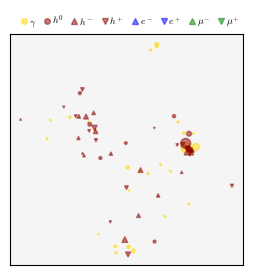

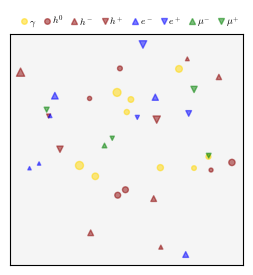

In [6]:
jets.display_cloud(0), noise.display_cloud(4, scale_marker=3.0)

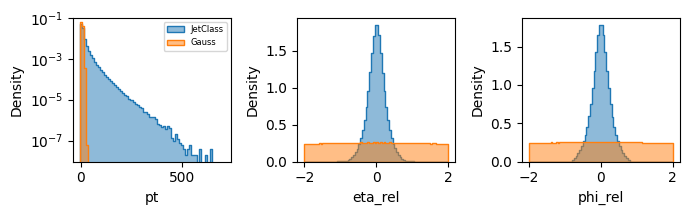

In [5]:
fig, ax = plt.subplots(1,3, figsize=(7,2.25))

binrange, binwidth = (-5,700), 10
jets.histplot('pt',  binwidth=binwidth, binrange=binrange, ax=ax[0], stat='density', alpha=0.5, log_scale=(False,True), label='JetClass')
noise.histplot('pt',binwidth=binwidth, binrange=binrange, ax=ax[0], stat='density', alpha=0.5, log_scale=(False,True), label='Gauss')

binrange, binwidth = (-2,2), 0.05
jets.histplot('eta_rel',  binwidth=binwidth, binrange=binrange, ax=ax[1], stat='density', alpha=0.5,  label='JetClass')
noise.histplot('eta_rel', binwidth=binwidth, binrange=binrange, ax=ax[1], stat='density', alpha=0.5,  label='Gauss')
jets.histplot('phi_rel',  binwidth=binwidth, binrange=binrange, ax=ax[2], stat='density', alpha=0.5, label='JetClass')
noise.histplot('phi_rel', binwidth=binwidth, binrange=binrange, ax=ax[2], stat='density', alpha=0.5, label='Gauss')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

### pre/post-processing checks

In [4]:
jets.preprocess(output_continuous='standardize', 
                output_discrete='states')

jets.stats

{'mean': [12.39120101928711, 0.00021292937162797898, 6.881651188450633e-06],
 'std': [21.185836791992188, 0.2585392892360687, 0.2526911497116089],
 'min': [0.07611234486103058, -3.171373128890991, -1.1424001455307007],
 'max': [707.906494140625, 3.1564340591430664, 1.0761349201202393]}

In [5]:
jets.continuous.shape, jets.mask.shape

(torch.Size([100000, 128, 3]), torch.Size([100000, 128, 1]))

In [7]:
torch.cat([jets.continuous, jets.discrete, jets.mask], dim=-1)[0][:5]

tensor([[ 1.9118,  0.9109,  0.2807,  1.0000,  1.0000],
        [ 1.8287,  0.9168,  0.1613,  0.0000,  1.0000],
        [ 1.6068,  0.9939,  0.0917,  2.0000,  1.0000],
        [ 0.6004,  1.1753,  0.1860,  0.0000,  1.0000],
        [ 0.1891, -0.6707, -2.4054,  2.0000,  1.0000]])

In [8]:
jets.postprocess(input_continuous='standardize', 
                 input_discrete='states')

In [9]:
torch.cat([jets.continuous, jets.discrete, jets.mask], dim=-1)[0][:5]

tensor([[ 5.2893e+01,  2.3572e-01,  7.0941e-02,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 5.1133e+01,  2.3724e-01,  4.0771e-02,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 4.6432e+01,  2.5717e-01,  2.3169e-02,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00,  1.0000e+00],
        [ 2.5112e+01,  3.0408e-01,  4.7000e-02,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 1.6397e+01, -1.7318e-01, -6.0781e-01,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00,  1.0000e+00]])

In [5]:
jets.preprocess(output_continuous='standardize', 
                output_discrete='onehot_dequantize')

jets.stats

{'mean': [12.39120101928711,
  0.00021292937162797898,
  6.881651188450633e-06,
  0.41356632113456726,
  0.10945022106170654,
  0.2323295623064041,
  0.23220109939575195,
  0.0038296147249639034,
  0.003814270254224539,
  0.002407107735052705,
  0.002401796169579029],
 'std': [21.185836791992188,
  0.2585392892360687,
  0.2526911497116089,
  0.4924726188182831,
  0.3122032880783081,
  0.42231810092926025,
  0.4222366511821747,
  0.06176527589559555,
  0.061641886830329895,
  0.049003202468156815,
  0.048949237912893295],
 'min': [0.07611234486103058,
  -3.171373128890991,
  -1.1424001455307007,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'max': [707.906494140625,
  3.1564340591430664,
  1.0761349201202393,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]}

In [7]:
jets.continuous.shape, jets.mask.shape

(torch.Size([100000, 128, 11]), torch.Size([100000, 128, 1]))

In [8]:
torch.cat([jets.continuous, jets.mask], dim=-1)[0][:5]

tensor([[ 1.9118,  0.9109,  0.2807, -0.8398,  2.8525, -0.5501, -0.5499, -0.0620,
         -0.0619, -0.0491, -0.0491,  1.0000],
        [ 1.8287,  0.9168,  0.1613,  1.1908, -0.3506, -0.5501, -0.5499, -0.0620,
         -0.0619, -0.0491, -0.0491,  1.0000],
        [ 1.6068,  0.9939,  0.0917, -0.8398, -0.3506,  1.8178, -0.5499, -0.0620,
         -0.0619, -0.0491, -0.0491,  1.0000],
        [ 0.6004,  1.1753,  0.1860,  1.1908, -0.3506, -0.5501, -0.5499, -0.0620,
         -0.0619, -0.0491, -0.0491,  1.0000],
        [ 0.1891, -0.6707, -2.4054, -0.8398, -0.3506,  1.8178, -0.5499, -0.0620,
         -0.0619, -0.0491, -0.0491,  1.0000]])

In [9]:
jets.postprocess(input_continuous='standardize', 
                 input_discrete='onehot_dequantize')

In [10]:
torch.cat([jets.continuous, jets.discrete, jets.mask], dim=-1)[0][:5]

tensor([[ 5.2893e+01,  2.3572e-01,  7.0941e-02,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 5.1133e+01,  2.3724e-01,  4.0771e-02,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 4.6432e+01,  2.5717e-01,  2.3169e-02,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00,  1.0000e+00],
        [ 2.5112e+01,  3.0408e-01,  4.7000e-02,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 1.6397e+01, -1.7318e-01, -6.0781e-01,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00,  1.0000e+00]])

In [10]:
torch.cat([jets.continuous, jets.discrete], dim=-1)[0, :20]

tensor([[ 5.2893e+01,  2.3572e-01,  7.0941e-02,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.1133e+01,  2.3724e-01,  4.0771e-02,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 4.6432e+01,  2.5717e-01,  2.3169e-02,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00],
        [ 2.5112e+01,  3.0408e-01,  4.7000e-02,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.6397e+01, -1.7318e-01, -6.0781e-01,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00],
        [ 1.5749e+01,  2.6327e-01,  1.9927e-03,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 1.3766e+01, -3.7694e-01,  1.8052e-01,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 1.2795e+01, -1.5121e-01, -7.1309e-01, 

### jet dataclass

In [3]:
from cmb.configs.utils import Configs

config = Configs('epic_hybrid.yaml') 
config.data.print()

INFO: created experiment instance GaussNoise_to_JetClass_FlowMatching_TelegraphProcess_HybridEPiC_2024.10.11_15h35_7700
target:
    name: JetClass
    tag: tbqq
    train_path: ['/home/df630/CMB/data/JetClass/TTBar_000.root', '/home/df630/CMB/data/JetClass/TTBar_001.root', '/home/df630/CMB/data/JetClass/TTBar_002.root']
    test_path: ['/home/df630/CMB/data/JetClass/TTBar_003.root']
    params:
        min_num_particles: 0
        max_num_particles: 128
source:
    name: GaussNoise
    params:
        scale: 1.0
        min_num_particles: 0
        max_num_particles: 128
dim:
    features:
        continuous: 3
        discrete: 1
    context:
        continuous: 0
        discrete: 0
vocab:
    size:
        features: 8
        context: 0
preprocess:
    continuous: standardize
    discrete: states


In [11]:
class JetsClassData:
    ''' class that prepares the source-target coupling
    '''
    def __init__(self, config, task):
        assert task=='train' or task=='test', 'Please specify downstream task: `train`, `test`'
        param_target = config.target.params.to_dict()
        param_source = config.source.params.to_dict()
        
        #...target:

        self.target = ParticleClouds(dataset=config.target.name,
                                     data_paths=getattr(config.target, 'train_path', None) if task == 'train' else getattr(config.target, 'test_path', None),
                                     **param_target)

        #... noise source:
        
        param_source['set_masks_like'] = self.target.multiplicity 
        param_source['num_jets'] = len(self.target)
        self.source = ParticleClouds(dataset=config.source.name,
                                     data_paths=getattr(config.source, 'train_path', None) if task == 'train' else getattr(config.source, 'test_path', None),
                                     **param_source)
            


In [12]:
jets = JetsClassData(config.data, 'train')

/home/df630/CMB/src/cmb/datasets/utils.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


(None, None)

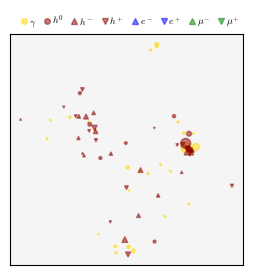

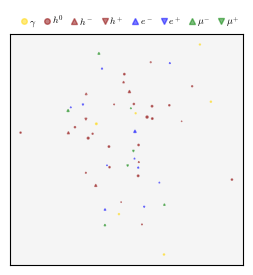

In [7]:
jets.target.display_cloud(0), jets.source.display_cloud(0)

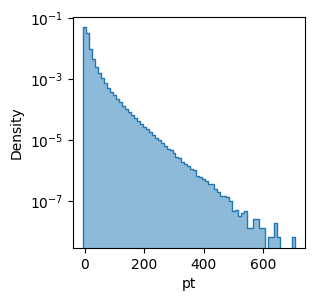

In [22]:
jets.target.histplot('pt',  binwidth=10, binrange=(-5,700), stat='density', alpha=0.5, log_scale=(False,True), label='JetClass')

In [13]:
len(jets.target), len(jets.source)

(300000, 300000)

### High-Level Features

In [20]:
import numpy as np
import torch
import awkward as ak
import fastjet
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

class JetClassHighLevelFeatures:
    def __init__(self, constituents: ParticleClouds):

        self.constituents = constituents

        #...compute jet kinematics:
        self.constituents.compute_4mom()
        self.px = self.constituents.px.sum(axis=-1)
        self.py = self.constituents.py.sum(axis=-1)
        self.pz = self.constituents.pz.sum(axis=-1)
        self.e = self.constituents.e.sum(axis=-1)
        self.pt = torch.clamp_min(self.px**2 + self.py**2, 0).sqrt()
        self.m = torch.clamp_min(self.e**2 - self.px**2 - self.py**2 - self.pz**2, 0).sqrt()
        self.eta = 0.5 * torch.log((self.pt + self.pz) / (self.pt - self.pz))
        self.phi = torch.atan2(self.py, self.px)

        # discrete jet features
        self.Q_total = self.jet_charge(kappa=0.0)
        self.Q_jet = self.jet_charge(kappa=1.0)
        self.multiplicity = torch.sum(self.constituents.mask, dim=1)

        #...subsstructure
        self.R = 0.8
        self.beta = 1.0
        self.use_wta_scheme = False
        self.substructure()

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), ax=None, **kwargs):
        x = getattr(self, features)
        if isinstance(x, torch.Tensor): x.cpu().numpy()
        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=x, element="step", ax=ax, **kwargs) 
        ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def jet_charge(self, kappa):
        ''' jet charge defined as Q_j^kappa = Sum_i Q_i * (pT_i / pT_jet)^kappa
        '''
        Qjet = self.constituents.charge * (self.constituents.pt)**kappa
        return Qjet.sum(axis=1) / (self.pt**kappa) 
    
    def histplot_multiplicities(self, state=None, xlim=None, ylim=None, xlabel=None, ylabel=None, figsize=(3,3), ax=None, **kwargs):
        if state is not None:
            if isinstance(state, int):
                state = [state]
            multiplicity = torch.zeros(self.constituents.discrete.shape[0], 1)
            for s in state:
                x = (torch.argmax(self.constituents.discrete, dim=-1).unsqueeze(-1) == s) * self.constituents.mask
                multiplicity += x.sum(dim=1)
        else:
            multiplicity = self.multiplicity

        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)   
        sns.histplot(x=multiplicity.squeeze(-1), element="step", ax=ax, discrete=True, **kwargs) 
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def flavor_fractions(self, figsize=(3,3), ax=None, **kwargs):
        if ax is None: 
            _, ax = plt.subplots(figsize=figsize)                                          
        sns.histplot(self.constituents.discrete[self.constituents.mask].squeeze(), binrange=(-0.1, 7.1), element="step", ax=ax, discrete=True, **kwargs)
        ax.legend(loc='upper right', fontsize=7)
        ax.set_xlabel('Particle flavor')
        ax.set_xticks(np.arange(8))
        ax.set_xticklabels([r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^-$', r'$\mu^+$'])

    def substructure(self):
        constituents_ak = ak.zip({ "pt": np.array(self.constituents.pt),
                                   "eta": np.array(self.constituents.eta_rel),
                                   "phi": np.array(self.constituents.phi_rel),
                                   "mass": np.zeros_like(np.array(self.constituents.pt))
                                   },
                                  with_name="Momentum4D")

        constituents_ak = ak.mask(constituents_ak, constituents_ak.pt > 0)
        constituents_ak = ak.drop_none(constituents_ak)
        self.constituents_ak = constituents_ak[ak.num(constituents_ak) >= 3]
        if self.use_wta_scheme:
            jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, self.R, fastjet.WTA_pt_scheme)
        else:
            jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, self.R)
        print("Clustering jets with fastjet")
        print("Jet definition:", jetdef)
        self.cluster = fastjet.ClusterSequence(constituents_ak, jetdef)
        self.inclusive_jets = self.cluster.inclusive_jets()
        self.exclusive_jets_1 = self.cluster.exclusive_jets(n_jets=1)
        self.exclusive_jets_2 = self.cluster.exclusive_jets(n_jets=2)
        self.exclusive_jets_3 = self.cluster.exclusive_jets(n_jets=3)
        print("Calculating N-subjettiness")
        self._calc_d0()
        self._calc_tau1()
        self._calc_tau2()
        self._calc_tau3()
        self.tau21 = np.ma.divide(self.tau2, self.tau1)
        self.tau32 = np.ma.divide(self.tau3, self.tau2)
        print("Calculating D2")
        # D2 as defined in https://arxiv.org/pdf/1409.6298.pdf
        self.d2 = self.cluster.exclusive_jets_energy_correlator(njets=1, func="d2")

    def _calc_deltaR(self, particles, jet):
        jet = ak.unflatten(ak.flatten(jet), counts=1)
        return particles.deltaR(jet)

    def _calc_d0(self):
        """Calculate the d0 values."""
        self.d0 = ak.sum(self.constituents_ak.pt * self.R**self.beta, axis=1)

    def _calc_tau1(self):
        """Calculate the tau1 values."""
        self.delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_1[:, :1])
        self.pt_i = self.constituents_ak.pt
        self.tau1 = ak.sum(self.pt_i * self.delta_r_1i**self.beta, axis=1) / self.d0

    def _calc_tau2(self):
        """Calculate the tau2 values."""
        delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_2[:, :1])
        delta_r_2i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_2[:, 1:2])
        self.pt_i = self.constituents_ak.pt
        # add new axis to make it broadcastable
        min_delta_r = ak.min(
            ak.concatenate(
                [
                    delta_r_1i[..., np.newaxis] ** self.beta,
                    delta_r_2i[..., np.newaxis] ** self.beta,
                ],
                axis=-1,
            ),
            axis=-1,
        )
        self.tau2 = ak.sum(self.pt_i * min_delta_r, axis=1) / self.d0

    def _calc_tau3(self):
        """Calculate the tau3 values."""
        delta_r_1i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, :1])
        delta_r_2i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, 1:2])
        delta_r_3i = self._calc_deltaR(self.constituents_ak, self.exclusive_jets_3[:, 2:3])
        self.pt_i = self.constituents_ak.pt
        min_delta_r = ak.min(
            ak.concatenate(
                [
                    delta_r_1i[..., np.newaxis] ** self.beta,
                    delta_r_2i[..., np.newaxis] ** self.beta,
                    delta_r_3i[..., np.newaxis] ** self.beta,
                ],
                axis=-1,
            ),
            axis=-1,
        )
        self.tau3 = ak.sum(self.pt_i * min_delta_r, axis=1) / self.d0

    def histogram(self, features='pt', density=True, num_bins=100, use_quantiles=False):
        x = getattr(self, features)
        bins = np.quantile(x, np.linspace(0.001, 0.999, num_bins)) if use_quantiles else num_bins
        return np.histogram(x, density=density, bins=bins)[0]

    def KLmetric1D(self, feature, reference, num_bins=100, use_quantiles=True):
        h1 = self.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        h2 = reference.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        return scipy.stats.entropy(h1, h2)  

    def Wassertein1D(self, feature, reference):
        x = getattr(self, feature)
        y = getattr(reference, feature)
        return scipy.stats.wasserstein_distance(x, y)
            



In [21]:
data = JetClassHighLevelFeatures(jets)

Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination


Calculating N-subjettiness
Calculating D2


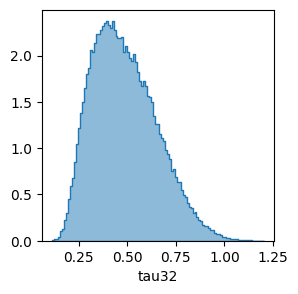

In [18]:
data.histplot('tau32', stat='density', alpha=0.5)

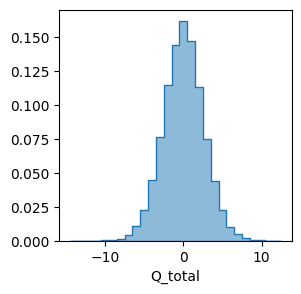

In [16]:
data.histplot('Q_total', discrete=True, stat='density', alpha=0.5)

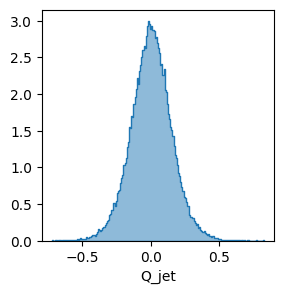

In [19]:
data.histplot('Q_jet', stat='density', alpha=0.5)

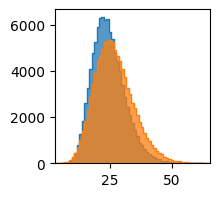

In [33]:
_, ax = plt.subplots(1,1, figsize=(2,2))
data.histplot_multiplicities(state=[2,3,4], ax=ax)
data.histplot_multiplicities(state=[0,1], ax=ax)


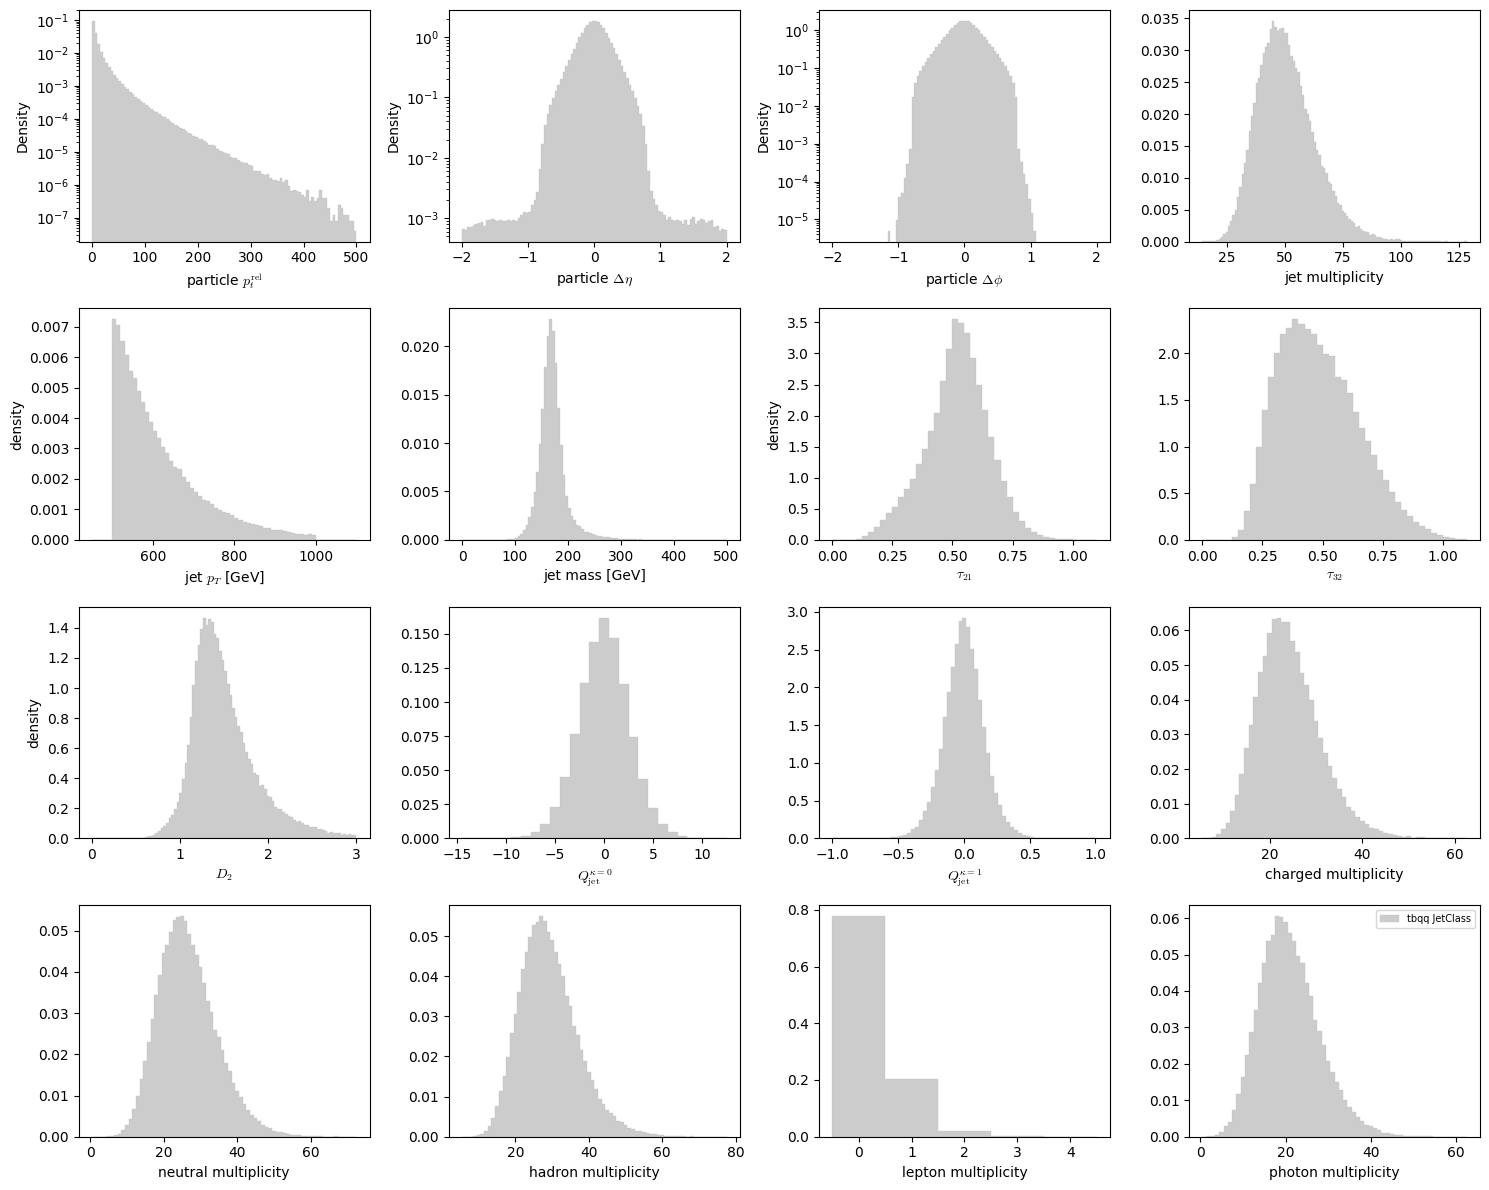

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

_, ax = plt.subplots(4,4,figsize=(15,12))

arg_test = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, False), color='silver', lw=0.25, label='tbqq JetClass')
arg_gen = dict(stat='density', fill=False,log_scale=(False, False), color='crimson', lw=1.25,  label='CMB')
arg_test_log = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, True), color='silver', lw=0.25, label='tbqq JetClass')
arg_gen_log = dict(stat='density', fill=False,log_scale=(False, True), color='crimson', lw=1.25,  label='CMB')


binrange, binwidth = (0, 500), 5
data.constituents.histplot('pt', binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_test_log)

binrange, binwidth = (-2, 2), 0.04
data.constituents.histplot('eta_rel',  binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_test_log)

binrange, binwidth = (-2, 2), 0.04
data.constituents.histplot('phi_rel', binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_test_log)


data.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_test)

# ------------------------------

binrange, binwidth = (450, 1100), 10
data.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_test)

binrange, binwidth = (0, 500), 5
data.histplot('m',  xlabel=r'jet mass [GeV]', ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_test)

binrange, binwidth, ylim = (0, 1.1), 0.025, (0, 4.0)
data.histplot('tau21',  xlabel=r'$\tau_{21}$', ylabel='density', ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_test)

data.histplot('tau32',  xlabel=r'$\tau_{32}$', ax=ax[1,3], binrange=binrange, binwidth=binwidth, **arg_test)


# ------------------------------

binrange, binwidth, ylim = (0, 3.0), 0.03, (0, 2.0)
data.histplot('d2',  xlabel=r'$D_2$', ylabel='density', ax=ax[2,0], binrange=binrange, binwidth=binwidth, **arg_test)

xlim, ylim = (-20, 20), (0, 0.2)
data.histplot('Q_total', xlabel=r'$Q_{\rm jet}^{\kappa=0}$',  discrete=True, ax=ax[2,1], **arg_test)

binrange, binwidth, ylim = (-1, 1), 0.03, (0.0, 4.0)
data.histplot('Q_jet', xlabel=r'$Q_{\rm jet}^{\kappa=1}$', binrange=binrange, binwidth=binwidth , ax=ax[2,2], **arg_test)

xlim, ylim = (0, 70), (0, 0.08)
data.histplot_multiplicities(state=[2,3,4], xlabel='charged multiplicity', ax=ax[2,3], **arg_test)

xlim, ylim = (0, 70), (0, 0.08)
data.histplot_multiplicities(state=[0,1], xlabel='neutral multiplicity', ax=ax[3,0], **arg_test)

xlim, ylim = (0, 70), (0, 0.08)
data.histplot_multiplicities(state=[1,2], xlabel='hadron multiplicity', ax=ax[3,1], **arg_test)

xlim = (-0.5,7)
data.histplot_multiplicities(state=[4,5], xlabel='lepton multiplicity', ax=ax[3,2], **arg_test)

xlim, ylim = (0, 50), (0, 0.08)
data.histplot_multiplicities(state=0, xlabel='photon multiplicity', ax=ax[3,3], **arg_test)

plt.legend(fontsize=7)

plt.tight_layout()
plt.show()